# Pre Processing

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
from PIL import Image
import shutil

# Define the paths
data_dir = "/kaggle/input/indonesian-batik-motifs"
desired_classes = ['batik-bali', 'batik-betawi', 'batik-keraton']

2024-06-23 04:55:43.956833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 04:55:43.956937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 04:55:44.088746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


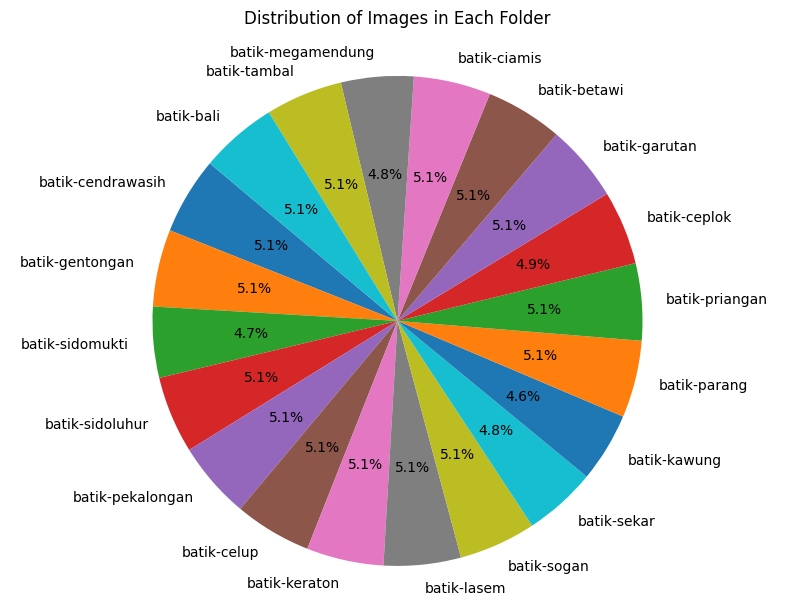

In [3]:
import os
import matplotlib.pyplot as plt

# Path to the main folder 'a'
main_folder_path = '/kaggle/input/indonesian-batik-motifs'

# Get list of subfolders in the main folder
subfolders = [f.path for f in os.scandir(main_folder_path) if f.is_dir()]

# Dictionary to store the count of images in each subfolder
image_counts = {}

# Supported image extensions
image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')

# Iterate through each subfolder and count images
for subfolder in subfolders:
    image_count = sum([len(files) for r, d, files in os.walk(subfolder) if any(file.endswith(image_extensions) for file in files)])
    folder_name = os.path.basename(subfolder)
    image_counts[folder_name] = image_count

# Prepare data for pie chart
labels = image_counts.keys()
sizes = image_counts.values()

# Plot pie chart
plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Set title with padding
plt.title('Distribution of Images in Each Folder', pad=20)  # Adjust the pad value as needed

# Display the pie chart
plt.show()




In [4]:
import os

# Path to the main folder 'a'
main_folder_path = '/kaggle/input/indonesian-batik-motifs'

# Get list of subfolders in the main folder
subfolders = [f.path for f in os.scandir(main_folder_path) if f.is_dir()]

# Dictionary to store the count of images in each subfolder
image_counts = {}

# Supported image extensions
image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')

# Iterate through each subfolder and count images
for subfolder in subfolders:
    image_count = sum([len(files) for r, d, files in os.walk(subfolder) if any(file.endswith(image_extensions) for file in files)])
    folder_name = os.path.basename(subfolder)
    image_counts[folder_name] = image_count

# Display the counts
for folder, count in image_counts.items():
    print(f"Folder {folder} contains {count} images.")


Folder batik-cendrawasih contains 50 images.
Folder batik-gentongan contains 50 images.
Folder batik-sidomukti contains 46 images.
Folder batik-sidoluhur contains 50 images.
Folder batik-pekalongan contains 50 images.
Folder batik-celup contains 50 images.
Folder batik-keraton contains 50 images.
Folder batik-lasem contains 50 images.
Folder batik-sogan contains 50 images.
Folder batik-sekar contains 47 images.
Folder batik-kawung contains 45 images.
Folder batik-parang contains 50 images.
Folder batik-priangan contains 50 images.
Folder batik-ceplok contains 48 images.
Folder batik-garutan contains 50 images.
Folder batik-betawi contains 50 images.
Folder batik-ciamis contains 50 images.
Folder batik-megamendung contains 47 images.
Folder batik-tambal contains 50 images.
Folder batik-bali contains 50 images.


In [5]:
# Ensure only desired classes are included
filtered_data_dir = os.path.join(data_dir, '/kaggle/working/filtered')
os.makedirs(filtered_data_dir, exist_ok=True)
for class_name in desired_classes:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.exists(class_dir):
        dest_dir = os.path.join(filtered_data_dir, class_name)
        if not os.path.exists(dest_dir):
            os.symlink(class_dir, dest_dir)  # create a symbolic link to the class directory


In [6]:
# Create directories for train, val, test splits
segmented_directory = os.path.join(filtered_data_dir, '/kaggle/working/segmented_batik')
for folder in ['train', 'val', 'test']:
    for class_name in desired_classes:
        os.makedirs(os.path.join(segmented_directory, folder, class_name), exist_ok=True)

# Split the data into train, validation, and test sets
train_size = 0.7
val_size = 0.1  # validation size
test_size = 0.2  # test size
for batik in desired_classes:
    folder_path = os.path.join(filtered_data_dir, batik)
    all_files = os.listdir(folder_path)
    
    length_train = round(len(all_files) * train_size)
    length_val = round(len(all_files) * val_size)
    
    train_files = all_files[:length_train]
    val_files = all_files[length_train:length_train + length_val]
    test_files = all_files[length_train + length_val:]
    
    splited_data = [("train", train_files), ("val", val_files), ("test", test_files)]
    
    for data_type, file_list in splited_data:
        target_dir = os.path.join(segmented_directory, data_type, batik)
        os.makedirs(target_dir, exist_ok=True)
        
        for filename in file_list:
            source_path = os.path.join(folder_path, filename)
            target_path = os.path.join(target_dir, filename)
            shutil.copy2(source_path, target_path)

# Load the data from the segmented directory
batch_size = 2048
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(segmented_directory, 'train'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(segmented_directory, 'val'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(segmented_directory, 'test'),
    image_size=(img_height, img_width),
    batch_size=32
)

train_data = train_ds.concatenate(test_ds)
train_data = train_data.concatenate(val_ds)
train_data = train_data.map(lambda x, y: x)

Found 105 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 30 files belonging to 3 classes.


In [5]:
# Convert the dataset to numpy array
train_data_np = np.concatenate(list(train_data.as_numpy_iterator()))

train_data_mean = np.mean(train_data_np)
train_data_std = np.std(train_data_np)

# Normalize the pixel values
def normalize(image, label):
    return (image - train_data_mean) / train_data_std, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimize the dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# From Scratch


In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU

num_classes = len(desired_classes)  
input_shape = (img_height, img_width, 3)

model = Sequential([
    Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001), input_shape=input_shape),
    BatchNormalization(), 
    LeakyReLU(alpha=0.1),
    Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)), 
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(), 
    LeakyReLU(alpha=0.1),
    Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 56, 56, 128)    │             

 Total params: 51,673,123 (197.12 MB)

 Trainable params: 51,671,203 (197.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

print("Evaluasi model pada data uji:")
loss, accuracy = model.evaluate(test_ds)
print("Akurasi: {:.2f}%".format(accuracy * 100))


Epoch 1/100


2024-06-21 17:26:53.955746: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[105,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[105,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-21 17:26:54.118641: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.7616, expected 4.09951
2024-06-21 17:26:54.118693: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.27579, expected 4.61371
2024-06-21 17:26:54.118702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.38094, expected 4.71886
2024-06-21 17:26:54.118710: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - accuracy: 0.3714 - loss: 1.6771

2024-06-21 17:27:36.225862: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.53173, expected 3.64863
2024-06-21 17:27:36.225945: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.90679, expected 5.02369
2024-06-21 17:27:36.225963: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 7.34085, expected 6.45775
2024-06-21 17:27:36.225981: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 6.00665, expected 5.12355
2024-06-21 17:27:36.225993: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.66198, expected 4.77889
2024-06-21 17:27:36.226004: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 7.31979, expected 6.43669
2024-06-21 17:27:36.226014: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.88499, expected 5.00189
2024-06-21 17:27:36.226024:

1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - accuracy: 0.3714 - loss: 1.6771 - val_accuracy: 0.3333 - val_loss: 1.4801 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - accuracy: 0.4095 - loss: 4.6910 - val_accuracy: 0.3333 - val_loss: 1.3900 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.3810 - loss: 3.1639 - val_accuracy: 0.3333 - val_loss: 1.2353 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.4571 - loss: 2.0308 - val_accuracy: 0.5333 - val_loss: 1.1630 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3714 - loss: 1.5891 - val_accuracy: 0.4667 - val_loss: 1.1786 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4095 - loss: 1.3945 - val_accuracy: 0.3333 - val_loss: 1.2346 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.4095 - loss: 1.337

2024-06-21 17:27:42.918424: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.61233, expected 3.04092
2024-06-21 17:27:42.918482: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.46627, expected 3.89485
2024-06-21 17:27:42.918491: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.41222, expected 3.84081
2024-06-21 17:27:42.918500: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.02418, expected 2.45277
2024-06-21 17:27:42.918507: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.88651, expected 3.31509
2024-06-21 17:27:42.918515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 4.18259, expected 3.61118
2024-06-21 17:27:42.918523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.50085, expected 2.92944
2024-06-21 17:27:42.918530: E external/local_xla/x

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4333 - loss: 1.2155
Akurasi: 43.33%


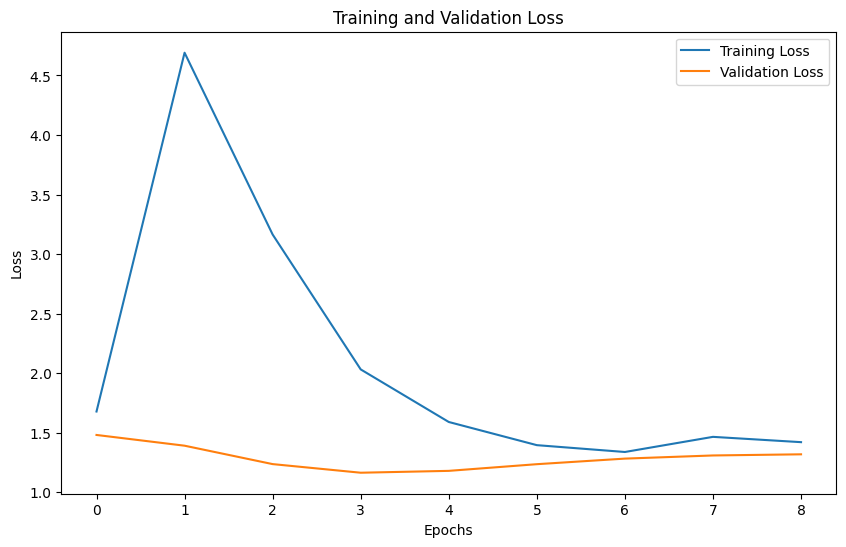

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Call the function to plot the loss
plot_loss(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


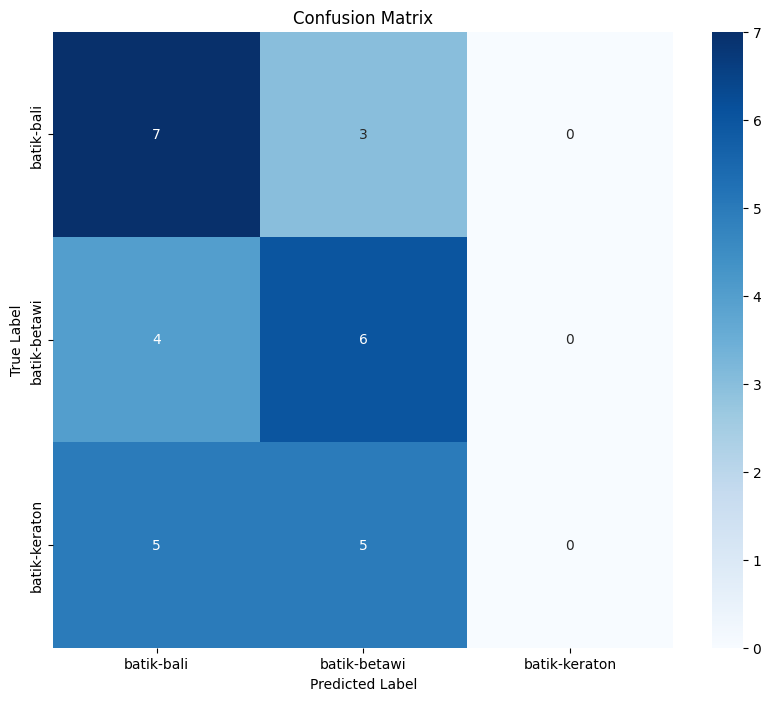

In [9]:
# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=desired_classes, yticklabels=desired_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=desired_classes)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
               precision    recall  f1-score   support

   batik-bali       0.44      0.70      0.54        10
 batik-betawi       0.43      0.60      0.50        10
batik-keraton       0.00      0.00      0.00        10

     accuracy                           0.43        30
    macro avg       0.29      0.43      0.35        30
 weighted avg       0.29      0.43      0.35        30



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras_tuner as kt

num_classes = len(desired_classes)  
input_shape = (img_height, img_width, 3)

def build_model(hp):
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(hp.Int('conv1_filters', min_value=16, max_value=64, step=16), 
                     3, padding='same', kernel_regularizer=regularizers.l2(0.0001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(hp.Int('conv2_filters', min_value=16, max_value=64, step=16), 
                     3, padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.3, step=0.1)))

    # Second Conv Block
    model.add(Conv2D(hp.Int('conv3_filters', min_value=32, max_value=128, step=32), 
                     3, padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(hp.Int('conv4_filters', min_value=32, max_value=128, step=32), 
                     3, padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.3, step=0.1)))

    # Third Conv Block
    model.add(Conv2D(hp.Int('conv5_filters', min_value=64, max_value=256, step=64), 
                     3, padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(hp.Int('conv6_filters', min_value=64, max_value=256, step=64), 
                     3, padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(hp.Float('dropout3', min_value=0.1, max_value=0.3, step=0.1)))

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), 
                    kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(hp.Float('dropout4', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Define tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=400,
    factor=3,
    directory='/kaggle/working/',
    project_name='intro_to_kt'
)

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(train_ds, validation_data=val_ds, epochs=400, callbacks=[early_stop])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print("Akurasi: {:.2f}%".format(accuracy * 100))


Trial 3 Complete [00h 00m 58s]

Best val_accuracy So Far: 0.3333333432674408
Total elapsed time: 00h 03m 31s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
16                |64                |conv1_filters
64                |16                |conv2_filters
0.1               |0.2               |dropout1
128               |96                |conv3_filters
64                |64                |conv4_filters
0.2               |0.2               |dropout2
128               |64                |conv5_filters
64                |128               |conv6_filters
0.1               |0.2               |dropout3
256               |128               |dense_units
0.2               |0.4               |dropout4
0.00068826        |1.9928e-05        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
5                 |5                 |tuner/bracket
0                 |0                 |tuner/roun

2024-06-21 17:32:32.658352: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50357: 2.3289, expected 1.99348
2024-06-21 17:32:32.658629: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 3.99893, expected 3.24321
2024-06-21 17:32:32.658649: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 6.05225, expected 5.29653
2024-06-21 17:32:32.658664: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 6.31342, expected 5.5577
2024-06-21 17:32:32.658685: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 6.02345, expected 5.26773
2024-06-21 17:32:32.658698: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 5.46419, expected 4.70847
2024-06-21 17:32:32.658710: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 5.67785, expected 4.92213
2024-06-21 17:32:32.658

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_34/632823907.py", line 83, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 233, in search

  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial

  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial

  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial

  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

Out of memory while trying to allocate 7230999240 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  210.82MiB
              constant allocation:       108B
        maybe_live_out allocation:  150.52MiB
     preallocated temp allocation:    6.73GiB
  preallocated temp fragmentation:   81.29MiB (1.18%)
                 total allocation:    6.94GiB
              total fragmentation:   82.82MiB (1.17%)
Peak buffers:
	Buffer 1:
		Size: 1.26GiB
		Operator: op_type="MaxPoolGrad" op_name="gradient_tape/sequential_1/max_pooling2d_1/MaxPool2d/MaxPoolGrad" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: select-and-scatter
		Shape: f32[105,224,224,64]
		==========================

	Buffer 2:
		Size: 1.26GiB
		Operator: op_type="LeakyRelu" op_name="sequential_1/leaky_re_lu_1_2/LeakyRelu" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: f32[105,64,224,224]
		==========================

	Buffer 3:
		Size: 1.26GiB
		Operator: op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[105,64,224,224]
		==========================

	Buffer 4:
		Size: 643.12MiB
		XLA Label: fusion
		Shape: f32[105,128,112,112]
		==========================

	Buffer 5:
		Size: 643.12MiB
		Operator: op_type="LeakyRelu" op_name="sequential_1/leaky_re_lu_2_1/LeakyRelu" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: f32[105,128,112,112]
		==========================

	Buffer 6:
		Size: 321.56MiB
		Operator: op_type="Mul" op_name="gradient_tape/sequential_1/dropout_1/stateless_dropout/Mul" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: f32[105,64,112,112]
		==========================

	Buffer 7:
		Size: 321.56MiB
		XLA Label: fusion
		Shape: f32[105,64,112,112]
		==========================

	Buffer 8:
		Size: 321.56MiB
		Operator: op_type="SelectV2" op_name="sequential_1/dropout_1/stateless_dropout/SelectV2" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: f32[105,64,112,112]
		==========================

	Buffer 9:
		Size: 321.56MiB
		Operator: op_type="LeakyRelu" op_name="sequential_1/leaky_re_lu_1/LeakyRelu" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: f32[105,16,224,224]
		==========================

	Buffer 10:
		Size: 321.56MiB
		Operator: op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[105,16,224,224]
		==========================

	Buffer 11:
		Size: 60.29MiB
		Operator: op_name="XLA_Args"
		XLA Label: fusion
		Shape: f32[105,3,224,224]
		==========================

	Buffer 12:
		Size: 60.29MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[105,224,224,3]
		==========================

	Buffer 13:
		Size: 49.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[50176,256]
		==========================

	Buffer 14:
		Size: 49.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[50176,256]
		==========================

	Buffer 15:
		Size: 49.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[50176,256]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_37489]


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Call the function to plot the loss
plot_loss(history)

In [ ]:
# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=desired_classes, yticklabels=desired_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=desired_classes)
print(report)


In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

num_classes = len(desired_classes)  
input_shape = (img_height, img_width, 3)

model = Sequential([
    Conv2D(16, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001), input_shape=input_shape),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.1),

    Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.1),

    Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.1),

    Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.1),

    GlobalAveragePooling2D(),

    Dense(1024, kernel_regularizer=regularizers.l2(0.0001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-6)

# Make sure to use the correct datasets
epochs = 100
history = model.fit(
    train_ds,  # Changed to use training data
    validation_data=val_ds,  # Changed to use validation data
    epochs=epochs,
    callbacks=[reduce_lr]  # Added early stopping callback
)

print("Evaluasi model pada data uji:")
loss, accuracy = model.evaluate(test_ds)
print("Akurasi: {:.2f}%".format(accuracy * 100))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,611 (908.64 KB)

 Trainable params: 232,611 (908.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.3714 - loss: 1.1303

2024-06-21 17:34:04.607063: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.58618, expected 3.64863
2024-06-21 17:34:04.607121: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.96124, expected 5.02369
2024-06-21 17:34:04.607130: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 7.39531, expected 6.45775
2024-06-21 17:34:04.607138: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 6.0611, expected 5.12355
2024-06-21 17:34:04.607146: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.71644, expected 4.77889
2024-06-21 17:34:04.607153: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 7.37424, expected 6.43669
2024-06-21 17:34:04.607161: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.93944, expected 5.00189
2024-06-21 17:34:04.607169: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.3714 - loss: 1.1303 - val_accuracy: 0.4000 - val_loss: 1.1340 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3524 - loss: 1.1541 - val_accuracy: 0.2667 - val_loss: 1.1334 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3714 - loss: 1.1301 - val_accuracy: 0.3333 - val_loss: 1.1340 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3429 - loss: 1.1415 - val_accuracy: 0.3333 - val_loss: 1.1347 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3333 - loss: 1.1465 - val_accuracy: 0.3333 - val_loss: 1.1343 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3048 - loss: 1.1596 - val_accuracy: 0.3333 - val_loss: 1.1339 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3524 - loss: 1.1718 - va

2024-06-21 17:34:13.707464: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.01676, expected 3.04092
2024-06-21 17:34:13.707521: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.52565, expected 5.54981
2024-06-21 17:34:13.707531: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.49189, expected 5.51604
2024-06-21 17:34:13.707540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.53901, expected 4.56316
2024-06-21 17:34:13.707548: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.87568, expected 4.89984
2024-06-21 17:34:13.707556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.95943, expected 4.98359
2024-06-21 17:34:13.707564: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.4166, expected 4.44075
2024-06-21 17:34:13.707572: E external/local_xla/xla/ser

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 1.1377
Akurasi: 40.00%


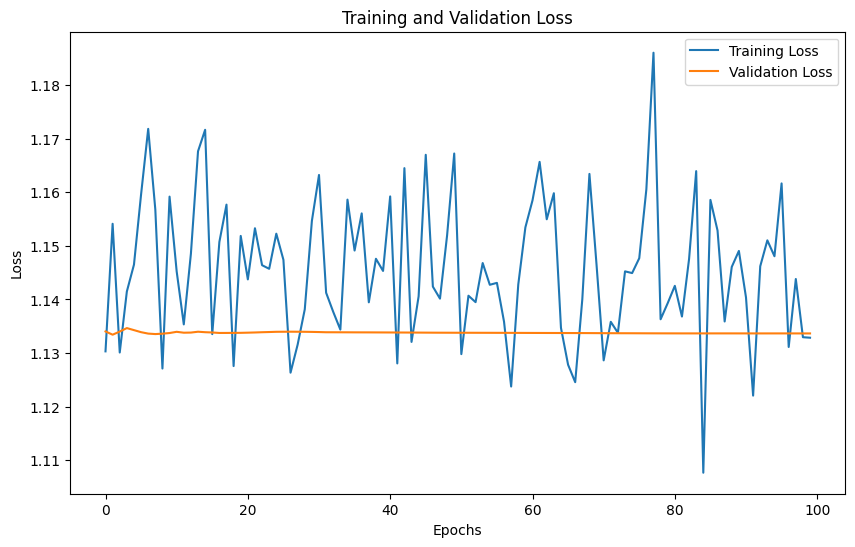

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Call the function to plot the loss
plot_loss(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


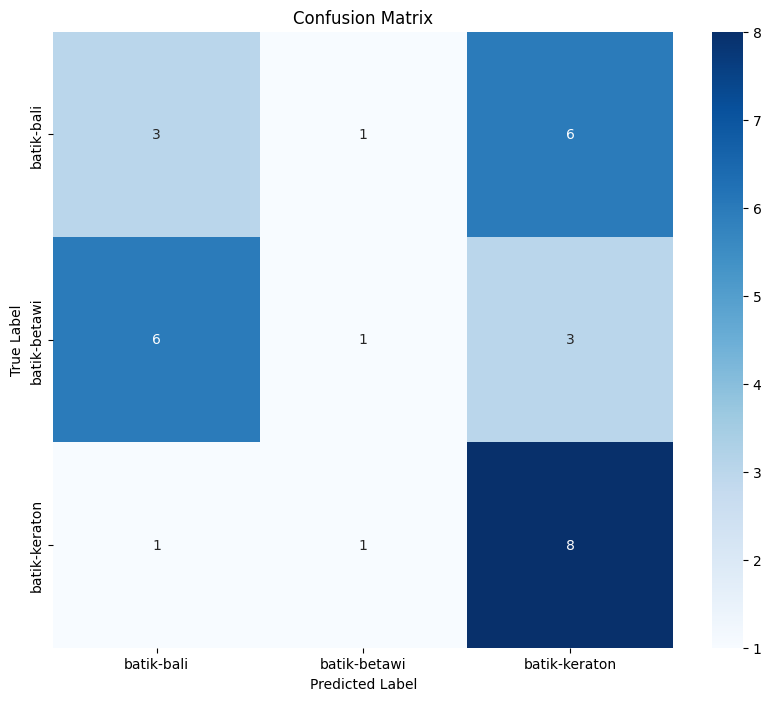

In [15]:
# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=desired_classes, yticklabels=desired_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=desired_classes)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
               precision    recall  f1-score   support

   batik-bali       0.30      0.30      0.30        10
 batik-betawi       0.33      0.10      0.15        10
batik-keraton       0.47      0.80      0.59        10

     accuracy                           0.40        30
    macro avg       0.37      0.40      0.35        30
 weighted avg       0.37      0.40      0.35        30



# DIY

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np


# Load the pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create the model architecture
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(desired_classes), activation='softmax')
])
model.build((None, img_height, img_width, 3))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Custom callback to save the best model based on val_loss, val_accuracy, and accuracy training
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', monitor2='val_accuracy', monitor3='accuracy', mode='min', mode2='max', mode3='max', save_best_only=True):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.monitor2 = monitor2
        self.monitor3 = monitor3
        self.mode = mode
        self.mode2 = mode2
        self.mode3 = mode3
        self.save_best_only = save_best_only
        self.best = np.Inf if mode == 'min' else -np.Inf
        self.best2 = -np.Inf if mode2 == 'max' else np.Inf
        self.best3 = -np.Inf if mode3 == 'max' else np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        current2 = logs.get(self.monitor2)
        current3 = logs.get(self.monitor3)
        
        if self.save_best_only:
            if self.mode == 'min' and self.mode2 == 'max' and self.mode3 == 'max':
                if current < self.best and current2 > self.best2 and current3 > self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
            elif self.mode == 'max' and self.mode2 == 'min' and self.mode3 == 'max':
                if current > self.best and current2 < self.best2 and current3 > self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
            elif self.mode == 'min' and self.mode2 == 'max' and self.mode3 == 'min':
                if current < self.best and current2 > self.best2 and current3 < self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
            elif self.mode == 'max' and self.mode2 == 'min' and self.mode3 == 'min':
                if current > self.best and current2 < self.best2 and current3 < self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
        else:
            self.model.save(self.filepath, overwrite=True)

# Define the custom checkpoint callback
custom_checkpoint = CustomModelCheckpoint('best_model_custom.h5', 
                                          monitor='val_loss', monitor2='val_accuracy', monitor3='accuracy', 
                                          mode='min', mode2='max', mode3='max', 
                                          save_best_only=True)

# Train the model with the custom checkpoint callback
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[reduce_lr, custom_checkpoint])

# Load the best model for fine-tuning
model = tf.keras.models.load_model('best_model_custom.h5')

# Unfreeze the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:len(base_model.layers) // 2]:
    layer.trainable = False

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Continue training with fine-tuning
history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=500,  # Adjust the number of epochs for fine-tuning
                         callbacks=[reduce_lr])

# Evaluate the fine-tuned model on the test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/working/segmented_batik/test',
    image_size=(img_height, img_width),
    batch_size=32)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy after fine-tuning: {test_acc}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.3238 - loss: 2.1503

I0000 00:00:1718999567.308762     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718999567.346268     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.3238 - loss: 2.1503 - val_accuracy: 0.2000 - val_loss: 2.2529 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3905 - loss: 1.9450 - val_accuracy: 0.1333 - val_loss: 2.2265 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4000 - loss: 1.9804 - val_accuracy: 0.1333 - val_loss: 2.2120 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3714 - loss: 1.9946 - val_accuracy: 0.1333 - val_loss: 2.2008 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4000 - loss: 1.9694 - val_accuracy: 0.2000 - val_loss: 2.1984 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.4000 - loss: 1.8577 - val_accuracy: 0.3333 - val_loss: 2.2018 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4000 - loss: 1.8936 - v

W0000 00:00:1718999590.905656     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4857 - loss: 1.8587 - val_accuracy: 0.4000 - val_loss: 2.1948 - learning_rate: 1.0000e-05
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4571 - loss: 1.8366 - val_accuracy: 0.4000 - val_loss: 2.1902 - learning_rate: 1.0000e-05
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5048 - loss: 1.7726 - val_accuracy: 0.4000 - val_loss: 2.1862 - learning_rate: 1.0000e-05
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3619 - loss: 1.8583 - val_accuracy: 0.4000 - val_loss: 2.1828 - learning_rate: 1.0000e-05
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4000 - loss: 1.8646 - val_accuracy: 0.4000 - val_loss: 2.1795 - learning_rate: 1.0000e-05
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5333 - loss: 1.7598 - val_accuracy: 0.4000 - val_loss: 2.1770 - learning_rate: 1.0000e-05
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3905 - loss: 1.9054 - va

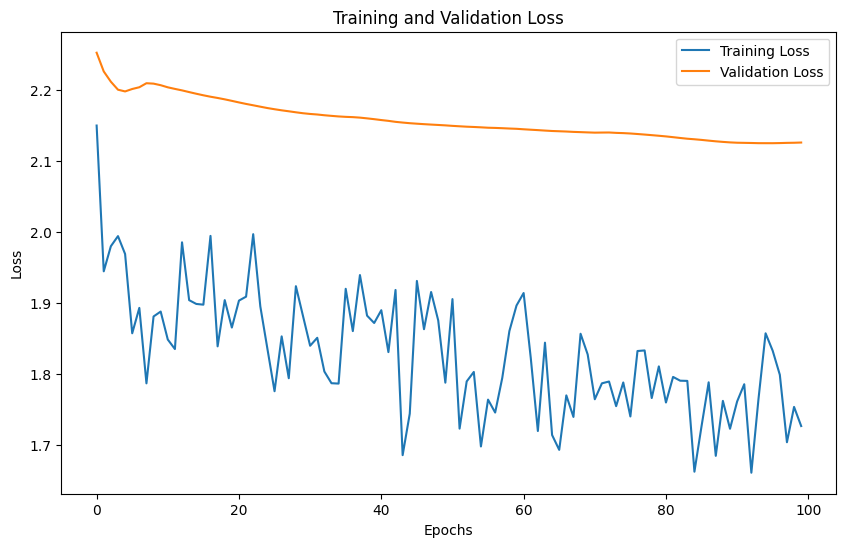

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Call the function to plot the loss
plot_loss(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


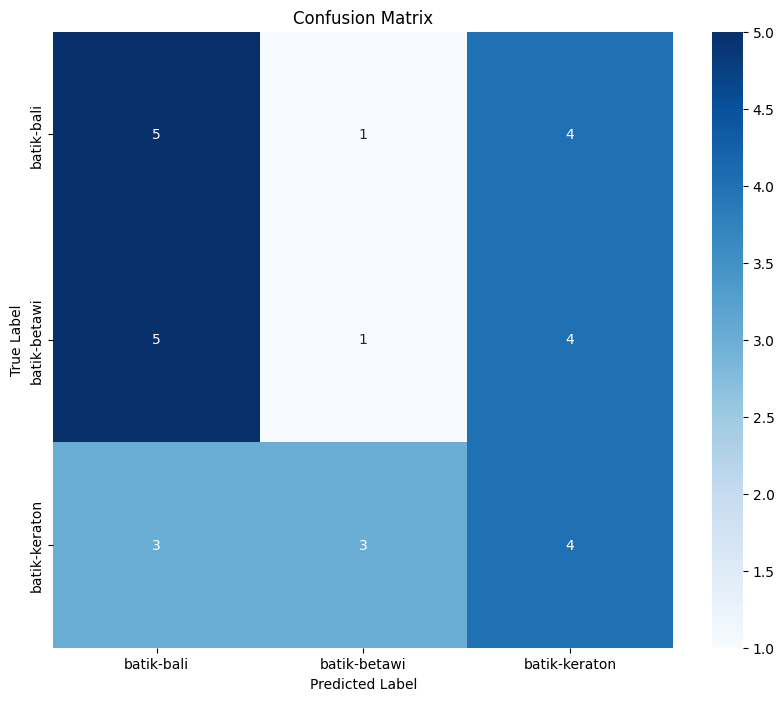

In [7]:
import seaborn as sns
# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=desired_classes, yticklabels=desired_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=desired_classes)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
               precision    recall  f1-score   support

   batik-bali       0.40      0.20      0.27        10
 batik-betawi       0.44      0.40      0.42        10
batik-keraton       0.44      0.70      0.54        10

     accuracy                           0.43        30
    macro avg       0.43      0.43      0.41        30
 weighted avg       0.43      0.43      0.41        30

